# Solving Mountain Car (Discrete) with a Genetic Algorithm

#### The Reward function has been changed. It gives the car a reward according to its maximum velocity along the episode altogether with the minimum distance to the goal

In [1]:
# Imports the libraries:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
import random
import gym


In [2]:
def createRandomIndividuals (numberOfIndividuals, numberOfParameters, low=-1, high=1):
    parameters = np.random.uniform (low=low, high = high, size = (numberOfParameters, numberOfIndividuals))
    return parameters

In [3]:
def elitismSelection (parameters, numberToBeChosen, shapes, paramsPerShape):
    scores  = [getMountainCarDiscreteFitness(parameters[:,i], shapes, paramsPerShape) for i in range(parameters.shape[1])]
    indices = np.argsort (scores)[::-1] # Really important for descending order!
    parameters      = parameters[:,indices[:numberToBeChosen]]
    print ("Best individual reward: %.2f" % scores[indices[0]])
    return parameters

In [4]:
def createPairs (numberOfSurvivors, numberOfPairs, replace=True): # It returns a list of indices that can be splitted every 2 for forming pairs
    pairs = []
    chosenIndices = np.random.choice (range(numberOfSurvivors), size=(numberOfPairs*2), replace = replace)
    return chosenIndices

In [5]:
def SBX (parameters1, parameters2, eta=100): # Simulated Binary Crossover. The bigger is eta, the more close the children are to parents

    r             = np.random.random(size=len(parameters1))
    gamma         = np.empty(len(parameters1))
    gamma[r<=0.5] = (2*r[r<=0.5])**(1/(eta+1))
    gamma[r>0.5 ] = (1/(2*(1-r[r>0.5])))**(1/(eta+1))
    child1        = 0.5 * ((1+gamma)*parameters1 + (1-gamma)*parameters2)
    child2        = 0.5 * ((1-gamma)*parameters1 + (1+gamma)*parameters2)
    return child1, child2

In [6]:
def applyGaussianMutation (parameters, mutation_rate=0.05, mu=0, sigma=1): # Pass it a numpy array of floats! (mu and sigma can be arrays too)
    mutationOrNot              = (np.random.random (size=len(parameters))) < mutation_rate
    mutationValues             = np.random.normal(loc=mu, scale = sigma, size = len(parameters))
    parameters[mutationOrNot] += mutationValues[mutationOrNot]
    return parameters

In [7]:
stateInput = keras.Input(shape = (2))

dense1 = keras.layers.Dense(units = 64, activation = "relu") (stateInput)

outputLayer = keras.layers.Dense (units = 3) (dense1)

model = keras.Model (inputs = stateInput, outputs = outputLayer)
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),loss ="mse")

In [8]:
def getLengthOfWeights (model):
    setsOfWeights = np.array(model.get_weights())
    totalWeights = 0
    shapes = []
    paramsPerShape = []
    for i in setsOfWeights:
        shapes.append(i.shape)
        i = np.reshape (i, (-1))
        totalWeights += i.shape[0]
        paramsPerShape.append(i.shape[0])
    return totalWeights, shapes, paramsPerShape

In [9]:
def setModelWeights(parameters, shapes, paramsPerShape):
    weights = []
    paramsUsedSoFar = 0
    for index, shape in enumerate (shapes):
        paramsInThisLayer = paramsPerShape[index]
        params = np.reshape (parameters[paramsUsedSoFar:paramsUsedSoFar+paramsInThisLayer], shape)
        weights.append(params)
        paramsUsedSoFar += paramsInThisLayer
    model.set_weights(weights)

In [10]:
def getMountainCarDiscreteFitness (parameters, shapes, paramsPerShape):
    
    setModelWeights (parameters, shapes, paramsPerShape)

    env = gym.make('MountainCar-v0')

    done = False
    mountainCarDiscreteReward = 0
    prevObs = np.expand_dims(env.reset(),axis=0)
    maximumVel = 0
    maximumDistRight = -1000
    
    for step in range(502):
        if (done):
            mountainCarDiscreteReward /= 2000
            mountainCarDiscreteReward += (maximumVel*10)
            mountainCarDiscreteReward += (maximumDistRight*0.1)
            if (state[0]>= 0.5):
                mountainCarDiscreteReward += 1
            break  
        env.render()
        action = np.argmax(model.predict(prevObs))

        state, reward, done,_ = env.step(action)
        if (np.abs(state[1]) > maximumVel):
            maximumVel = np.abs(state[1])
        if (state[0] > maximumDistRight):
            maximumDistRight = state[0]
        prevObs = np.expand_dims(state,axis=0)
       
        mountainCarDiscreteReward += reward
    
    env.close()
    return mountainCarDiscreteReward

In [11]:
numberOfGenerations = 15
indivPerGen         = 100
fittestNumber       = 30

childrenFromParents = 80
parentsThatRemain   = 10
numberNewIndividuals= 10

mu = 0
sigma = 0.2


totalWeights, shapes, paramsPerShape = getLengthOfWeights (model)

primitiveGeneration = createRandomIndividuals (numberOfIndividuals=indivPerGen, numberOfParameters = totalWeights, low=-1, high=1)
# Shape (NumberOfWeights, indivPerGen).

pastGeneration   = np.copy(primitiveGeneration)

for i in range (numberOfGenerations):
    print ("Generation %d starting" % (i+1))
    # Choose one selection type:
    mutation_rate = 0.05/np.cbrt(i+1)
    survivors    = elitismSelection (pastGeneration, numberToBeChosen=fittestNumber, shapes=shapes, paramsPerShape = paramsPerShape)
    # Shape (NumberOfWeights, fittestNumber)

    pairs        = createPairs (numberOfSurvivors=fittestNumber, numberOfPairs = childrenFromParents//2, replace=True)
    # Shape (childrenFromParents,). Contains indices for survivors Array ready to be splitted every two.

    newChildren  = []

    for i in range (childrenFromParents//2):

        parents  = survivors[:,pairs[2*i:2*(i+1)]]
        # Shape (NumberOfWeights, numberOfParents)
        
        child1, child2 = SBX (parents[:,0], parents[:,1]) 
    
        # Choose one mutation type:

        child1, child2 = applyGaussianMutation (child1, mutation_rate=mutation_rate,mu=mu, sigma=sigma), applyGaussianMutation (child2,mutation_rate=mutation_rate, mu=mu, sigma=sigma)


        newChildren.append(child1)
        newChildren.append(child2)
    
    newChildren    = np.swapaxes(newChildren, axis1=1, axis2=0)
    # Shape (NumberOfWeights, ChildrenFromParents).

    newIndividuals = createRandomIndividuals (numberNewIndividuals, numberOfParameters = totalWeights, low=-1, high=1)
    # Shape (NumberOfWeights, numberNewIndividuals)
    
    newGeneration  = np.concatenate ((survivors[:,:parentsThatRemain],newChildren, newIndividuals), axis = 1)
    # Shape (NumberOfWeights, indivPerGen)

    pastGeneration = np.copy(newGeneration)
getMountainCarDiscreteFitness(survivors[:,0], shapes, paramsPerShape)

Generation 1 starting
Best individual reward: 0.07
Generation 2 starting
Best individual reward: 0.36
Generation 3 starting
Best individual reward: 0.54
Generation 4 starting
Best individual reward: 0.57
Generation 5 starting
Best individual reward: 0.57
Generation 6 starting
Best individual reward: 0.63
Generation 7 starting
Best individual reward: 1.60
Generation 8 starting
Best individual reward: 1.60
Generation 9 starting
Best individual reward: 1.60
Generation 10 starting
Best individual reward: 1.60
Generation 11 starting
Best individual reward: 1.61
Generation 12 starting
Best individual reward: 1.60
Generation 13 starting
Best individual reward: 1.61
Generation 14 starting
Best individual reward: 1.65
Generation 15 starting
Best individual reward: 1.66


1.604321953542205

## Once the agent had been trained, the reward function was changed to the official one for testing:

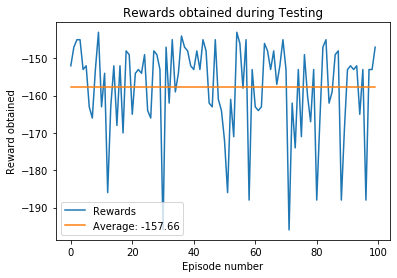

In [12]:
def testEnvironment ():
    rewards = []
    for episode in range (100):
        env = gym.make('MountainCar-v0')

        done = False
        mountainCarDiscreteReward = 0
        prevObs = np.expand_dims(env.reset(),axis=0)

        for step in range(502):
            if (done):
                break  
            #env.render()
            action = np.argmax(model.predict(prevObs))

            state, reward, done,_ = env.step(action)

            prevObs = np.expand_dims(state,axis=0)

            mountainCarDiscreteReward += reward
        env.close()
        rewards.append(mountainCarDiscreteReward)
        
    
    plt.plot (list(range(len(rewards))),rewards)
    plt.plot (list(range(len(rewards))), [np.average(rewards)]*len(rewards))
    plt.title("Rewards obtained during Testing")
    plt.xlabel("Episode number")
    plt.ylabel("Reward obtained")
    plt.legend(["Rewards", "Average: %.2f" % np.average(rewards)])
    plt.show()
testEnvironment()